<div style="text-align: center; padding: 30px; background: linear-gradient(90deg, #1e3c72, #2a5298); color: white; border-radius: 15px;">
    <h1>Прогнозирование стоимости компаний</h1>
    <h2>Полный исследовательский анализ + путь команды</h2>
    <h3>Team Dream | Кейс №8 УрФУ 2025</h3>
</div>

## О команде и распределении ролей
- **Буржимский Сергей** — Team Lead, постановка задач, дедлайны, продуктовые метрики, SHAP
- **Ли Сюань Линь** — EDA, визуализации
- **Халиков Рифат** — предобработка, генерация признаков
- **Карманов Максим** — обучение моделей, эксперименты
- **Рыжков Максим** — интерпретация, защита
- **Перминов Артём** — финальная модель XGBoost, красивые графики, ноутбуки
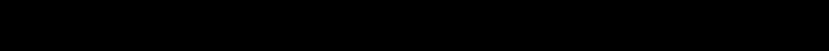
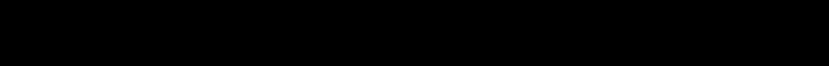
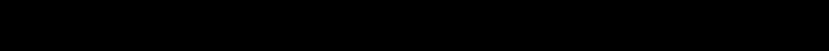
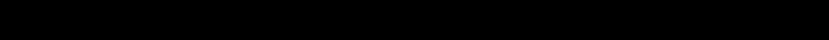
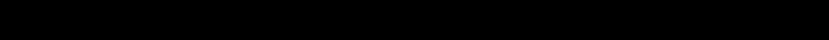
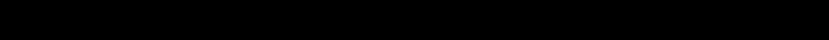

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (16,10), 'axes.titlesize': 22, 'axes.labelsize': 16, 'savefig.dpi': 400})
sns.set_style('whitegrid')
colors = ['#2c3e50', '#e74c3c', '#3498db', '#f39c12', '#1abc9c']

In [33]:
df = pd.read_csv('../data/financials.csv')
print(f"Размер: {df.shape}")
df.head()

Размер: (505, 14)


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387211e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813863e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


## Главная проблема: сильный перекос распределения
→ 10 компаний держат >50% всей капитализации
→ Линейные модели и обычные бустинги давали R² < 0.5

**Решение:** `log1p(Market Cap)` → почти нормальное распределение

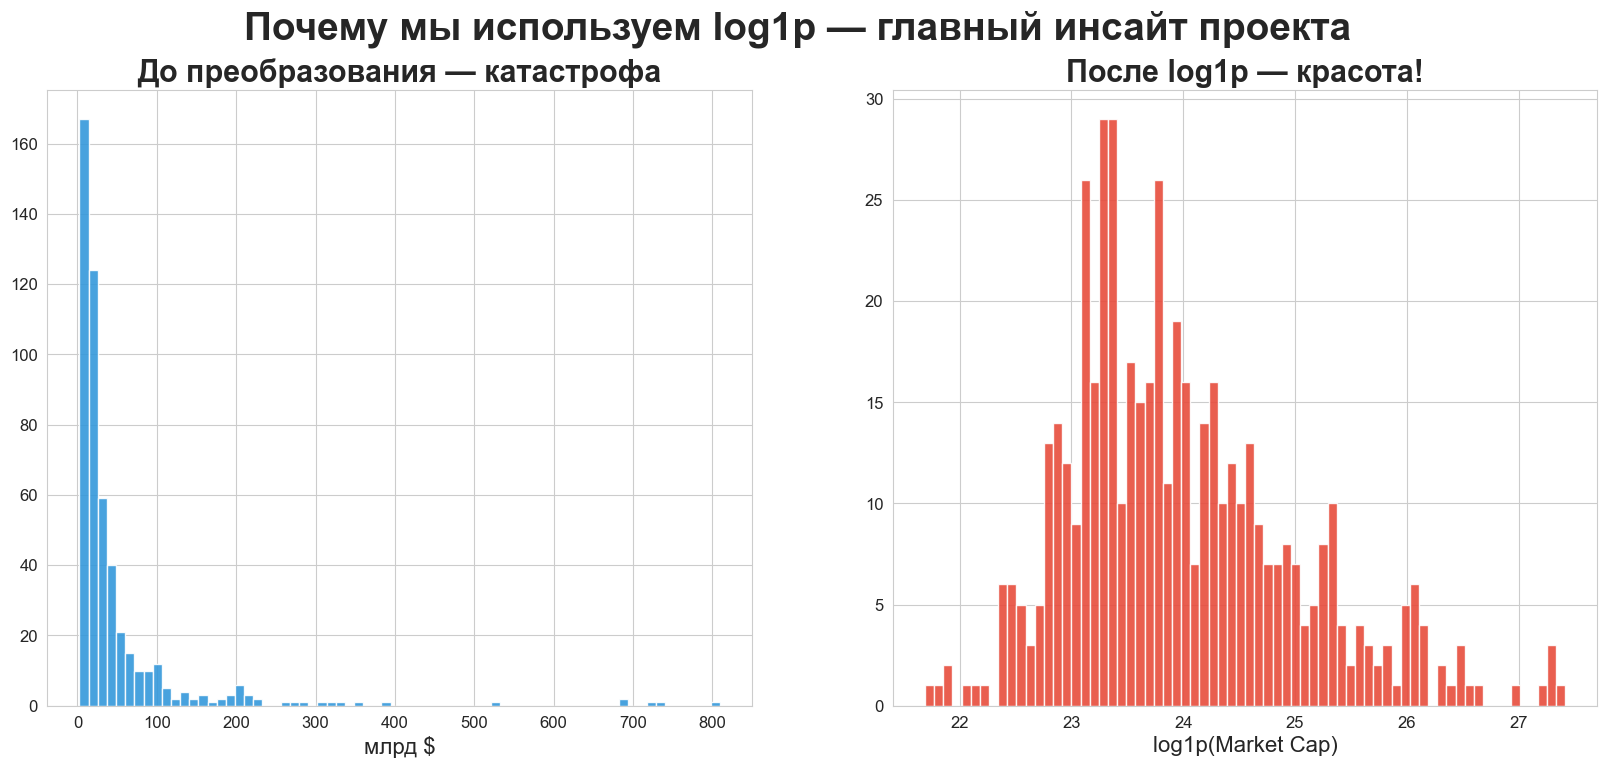

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].hist(df['Market Cap']/1e9, bins=70, color=colors[2], alpha=0.9, edgecolor='white')
axes[0].set_title('До преобразования — катастрофа', fontweight='bold')
axes[0].set_xlabel('млрд $')

df['Market Cap_log'] = np.log1p(df['Market Cap'])
axes[1].hist(df['Market Cap_log'], bins=70, color=colors[1], alpha=0.9, edgecolor='white')
axes[1].set_title('После log1p — красота!', fontweight='bold')
axes[1].set_xlabel('log1p(Market Cap)')

plt.suptitle('Почему мы используем log1p — главный инсайт проекта', fontsize=28, fontweight='bold')
plt.show()

## Корреляция по модулю — наш второй ключевой приём
→ Хотели видеть только силу связи, а не знак

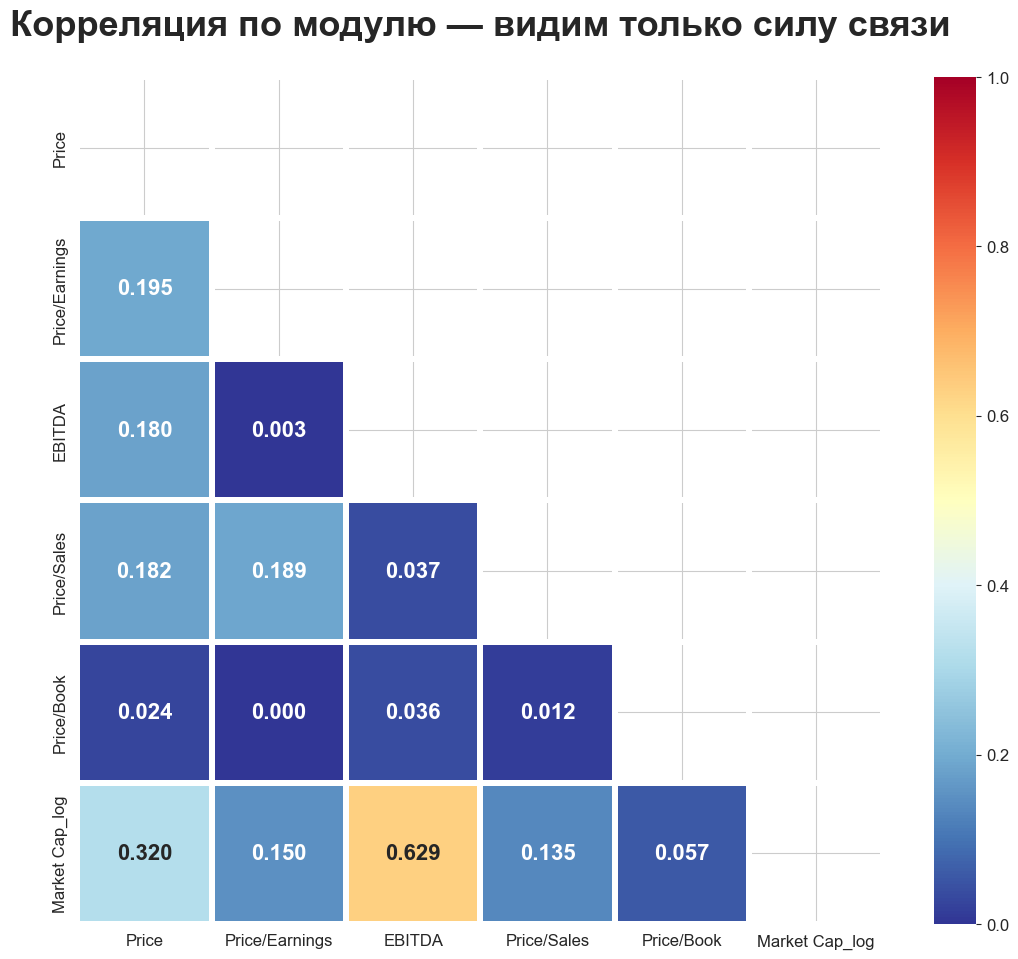

In [35]:
cols = ['Price', 'Price/Earnings', 'EBITDA', 'Price/Sales', 'Price/Book', 'Market Cap_log']
corr = df[cols].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(13,11))
sns.heatmap(corr, mask=mask, annot=True, fmt='.3f', cmap='RdYlBu_r', vmin=0, vmax=1,
            linewidths=3, linecolor='white', annot_kws={"size": 16, "weight": "bold"})
plt.title('Корреляция по модулю — видим только силу связи', fontsize=26, fontweight='bold', pad=30)
plt.show()

## Выводы из EDA
- EBITDA — король (корреляция > 0.9)
- Мультипликаторы важнее цены акции
- Без логарифмирования — провал
- 505 строк — мало, поэтому 5-fold CV + hold-out